# Training AlexNet on CIFAR-10 dataset

We built the [AlexNet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) model based on [this](https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98) tutorial (code available [here](https://github.com/RichmondAlake/tensorflow_2_tutorials/blob/master/015_alexnet.ipynb)).

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
from datetime import datetime

In [2]:
# comment out those two lines if not using Google Colab with Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

#save_path = f'/content/drive/MyDrive/Studium/Master/1. Semester/Machine Learning/ex3/CIFAR-10/AlexNet/{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}/'
save_path = f'./CIFAR-10/AlexNet/{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}/'# use this when running locally

## Load data

In [3]:
!ls

AlexNet_3_epoch_results.ipynb	    GTSRB
AlexNet_3_epoch_results_eval.ipynb  data
AlexNet_CIFAR-10.ipynb		    ex3
AlexNet_GTSRB.ipynb		    local_results_AlexNet.zip
AlexNet_Keras.ipynb		    ml-ex3


In [4]:
!git clone https://github.com/Sejmou/ml-ex3.git

fatal: destination path 'ml-ex3' already exists and is not an empty directory.


In [5]:
import sys
sys.path.append('./ml-ex3/')# make script files in ml-ex3 accessible

In [6]:
from data_loaders import CIFAR10Loader

In [7]:
IMG_WIDTH = IMG_HEIGHT = 257 # AlexNet expects images of size 257 x 257 as input

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = CIFAR10Loader('./data/CIFAR-10').get_processed_imgs(target_width = 32, target_height = 32)# cannot resize to 257 directly, our implementation is too RAM-hungry

Finished downloading required files for {self.DATA} dataset
loading training images and labels
loading test images and labels
done
processing training images
processing test images
done processing, creating train/val/test split


In [9]:
def resize_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    return image, label

In [10]:
NUM_CLASSES = len(np.unique(y_test))

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
validation_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

import gc
# make sure we get rid of all unused memory; we need every little piece of RAM!
del X_train
del y_train
del X_test
del y_test
del X_val
del y_val
gc.collect()

0

In [12]:
train_ds_size = len(list(train_ds))
train_ds_size = len(list(test_ds))
validation_ds_size = len(list(validation_ds))

In [13]:
train_ds = (train_ds
                  .map(resize_images)
                  #.shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=8, drop_remainder=True))

test_ds = (test_ds
                  .map(resize_images)
                  #.shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=8, drop_remainder=True))

validation_ds = (validation_ds
                  .map(resize_images)
                  #.shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=8, drop_remainder=True))

## Defining The Model

In [14]:
def create_AlexNet():
  return keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(IMG_WIDTH,IMG_HEIGHT,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

In [15]:
model = create_AlexNet()

In [16]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                        

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### Callbacks (for looking at results, storing checkpoints (weights of model across epochs), fit time)

In [17]:
root_logdir = save_path + 'tensor_board'

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [18]:
checkpoint_path = save_path + "checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [19]:
time_path = save_path + 'fit_times.csv'

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
      epoch_fit_time = time.time() - self.epoch_time_start
      with open(time_path, 'a') as f:
        f.write(f'{batch},{epoch_fit_time}\n')
      self.times.append(epoch_fit_time)

time_cb = TimeHistory()

In [20]:
model.fit(train_ds,
          epochs=50,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb, checkpoint_cb, time_cb])

Epoch 1/50
4375/4375 [==============================] - ETA: 0s - loss: 1.9478 - accuracy: 0.3577
Epoch 1: saving model to ./CIFAR-10/AlexNet/2022-02-18_20-44-29/checkpoints/cp-0001.ckpt
4375/4375 [==============================] - 153s 34ms/step - loss: 1.9478 - accuracy: 0.3577 - val_loss: 1.3588 - val_accuracy: 0.5123
Epoch 2/50
4375/4375 [==============================] - ETA: 0s - loss: 1.4704 - accuracy: 0.4798
Epoch 2: saving model to ./CIFAR-10/AlexNet/2022-02-18_20-44-29/checkpoints/cp-0002.ckpt
4375/4375 [==============================] - 143s 33ms/step - loss: 1.4704 - accuracy: 0.4798 - val_loss: 1.2223 - val_accuracy: 0.5687
Epoch 3/50
4375/4375 [==============================] - ETA: 0s - loss: 1.2875 - accuracy: 0.5429
Epoch 3: saving model to ./CIFAR-10/AlexNet/2022-02-18_20-44-29/checkpoints/cp-0003.ckpt
4375/4375 [==============================] - 144s 33ms/step - loss: 1.2875 - accuracy: 0.5429 - val_loss: 1.0972 - val_accuracy: 0.6116
Epoch 4/50
4375/4375 [=========

4375/4375 [==============================] - 149s 34ms/step - loss: 0.0927 - accuracy: 0.9703 - val_loss: 0.9210 - val_accuracy: 0.7771
Epoch 26/50
4375/4375 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.9733
Epoch 26: saving model to ./CIFAR-10/AlexNet/2022-02-18_20-44-29/checkpoints/cp-0026.ckpt
4375/4375 [==============================] - 149s 34ms/step - loss: 0.0817 - accuracy: 0.9733 - val_loss: 0.9248 - val_accuracy: 0.7790
Epoch 27/50
4375/4375 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9767
Epoch 27: saving model to ./CIFAR-10/AlexNet/2022-02-18_20-44-29/checkpoints/cp-0027.ckpt
4375/4375 [==============================] - 149s 34ms/step - loss: 0.0733 - accuracy: 0.9767 - val_loss: 0.9440 - val_accuracy: 0.7815
Epoch 28/50
4375/4375 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9773
Epoch 28: saving model to ./CIFAR-10/AlexNet/2022-02-18_20-44-29/checkpoints/cp-0028.ckpt
4375/4375 [==============

## Evaluation on test data

In [39]:
pred_start = time.time()
model.evaluate(test_ds)
prediction_time = time.time() - pred_start
print(f'Prediction took {prediction_time} seconds')

1250/1250 [==============================] - 13s 10ms/step - loss: 1.1490 - accuracy: 0.7808
Prediction took 12.996456384658813 seconds


Let's look at the results in detail:

In [22]:
y_preds = model.predict(test_ds)# matrix; row: observation, col: prob. for class
y_pred = np.argmax(y_preds, axis=1)

In [23]:
y_pred.shape

(10000,)

In [24]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [25]:
y_test.shape

(10000,)

In [26]:
print('Test Data accuracy(%): ', accuracy_score(y_test, y_pred)*100)

Test Data accuracy(%):  78.08


In [27]:
cf = confusion_matrix(y_test, y_pred)

In [30]:
# mapping of numeric label to text label
text_labels = { 0:'Airplane',
            1:'Automobile', 
            2:'Bird', 
            3:'Cat', 
            4:'Deer', 
            5:'Dog', 
            6:'Frog', 
            7:'Horse', 
            8:'Ship', 
            9:'Truck'}

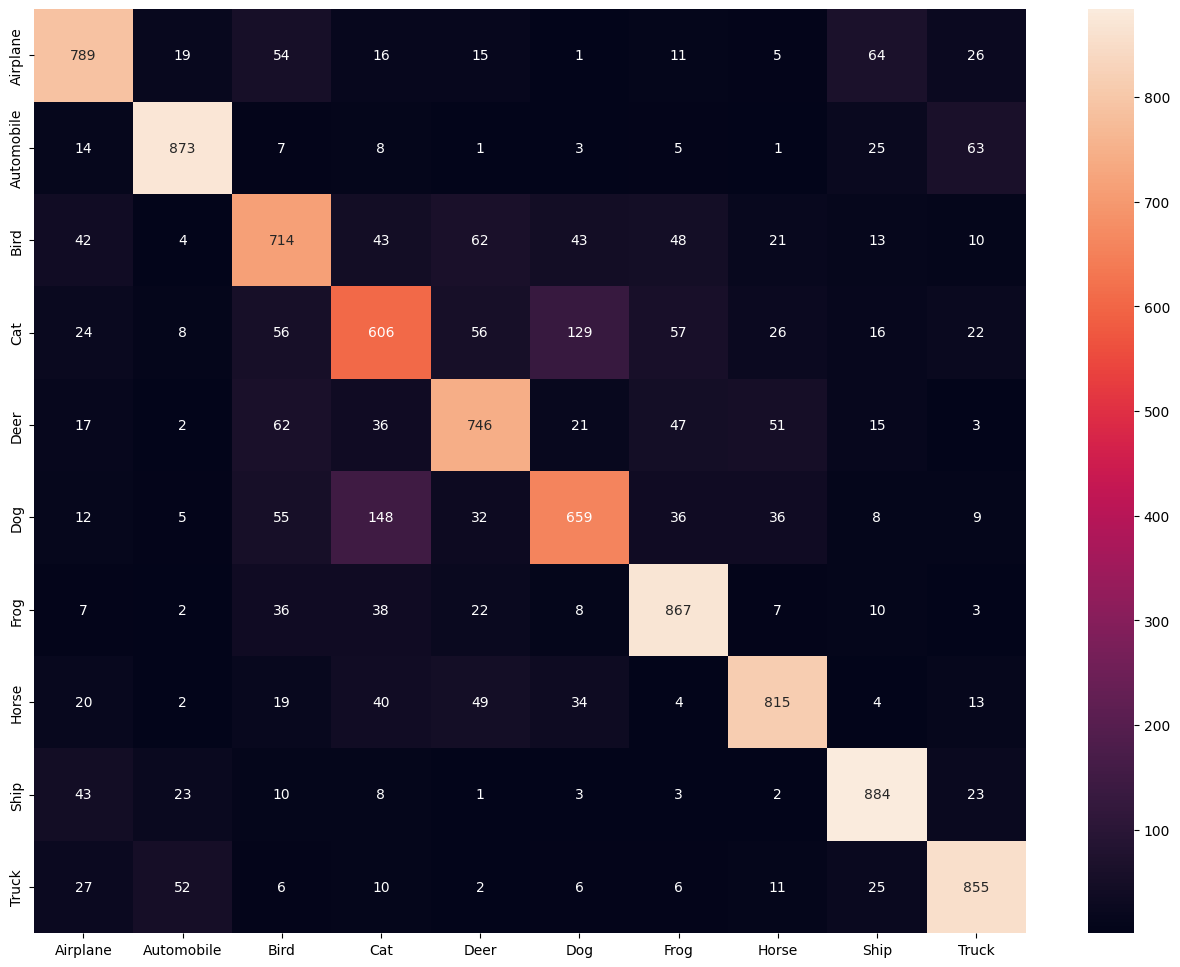

In [37]:
keys, values = zip(*text_labels.items())
df_cm = pd.DataFrame(cf, index = values,  columns = values)
plt.figure(figsize = (16,12))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [32]:
print(classification_report(y_test, y_pred, labels=keys, target_names=values))

              precision    recall  f1-score   support

    Airplane       0.79      0.79      0.79      1000
  Automobile       0.88      0.87      0.88      1000
        Bird       0.70      0.71      0.71      1000
         Cat       0.64      0.61      0.62      1000
        Deer       0.76      0.75      0.75      1000
         Dog       0.73      0.66      0.69      1000
        Frog       0.80      0.87      0.83      1000
       Horse       0.84      0.81      0.83      1000
        Ship       0.83      0.88      0.86      1000
       Truck       0.83      0.85      0.84      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

